# Disease Spread

With the outbreak of the *coronavirus* (COVID-19) in late 2019 and early 2020 there has been an increased interest in modeling the impacts of epidemic and pandemic. Live organisms, and particularly human beings, interact in cmplex ways and are highly dynamic, so trying to capture every movement, every surface touched, every contact between two or more individuals for every human being seems impossible. 

However, with the increasing number of georeferenced information about our commuting patterns, traffic congestions, maps of roads and subways, population demographics, improved weather observation and forecasts, and overall knowledge about human activity patterns based on circadian cycles and human preferences (e.g. peak times of internet demand, store hours, weekend activities, etc.) it is possible to generate robust simulation scenarios.

Incorporating these and many more variables, even for small country, could take substantil computing power and an interdisciplinary group of specilists. In this exercise we will implement a simplistic simulation to analyze the impact of few paramters on the spread of a made-up disease within an arbitrary small population. We will take into account social distancing and rate at which individuals move. The goal is to learn how to implement simple interactions and to  realize the level of complexity of more advanced models.

The code below is by no means intended for research use, but it may serve as the basis for craeting simple, but meaningful models, perhaps within confined systems such as animals in a pasture.

In [163]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output


In [4]:
# Define function to compute euclidean distance
def edist(x,y):
    df = np.kron(np.ones(N),[x,y]) - np.kron([x,y],np.ones(N)) # Compute differences
    E = np.sqrt(df[0]**2 + df[1]**2) # Compute Euclidean distance.
    E = np.reshape(E,[N,N])
    return E


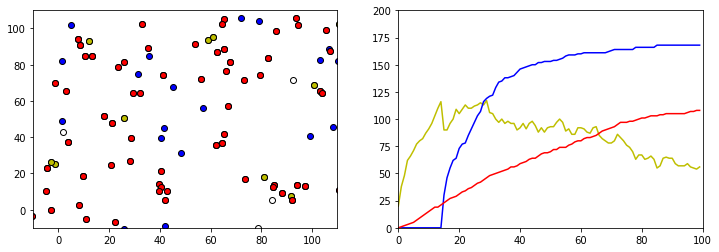

In [303]:
# Simulation constants
xmin = 0
xmax = 100
ymin = 0
ymax = 100
N = 200
T = 100

# Initial positions and directions
x = np.random.uniform(xmin,xmax,N)
y = np.random.uniform(ymin,ymax,N)
theta = np.radians(np.random.uniform(0,360,N))

# Compute percentage of people circulating
activity_rate = np.ones(N)
fraction_static = 0.1
static_individuals = np.random.randint(low=0, high=N, size=round(N*fraction_static))
activity_rate[static_individuals] = 0 

# Social distance
social_distance = 5 # arbitrary units

# Initial health conditions
dead = np.zeros(N, dtype=bool)
infected = np.zeros(N, dtype=bool)
recovered = np.zeros(N, dtype=bool)
normal = np.ones(N, dtype=bool)

# Death rate 
death_rate = 2/100

# Track quanrentine time for infected
quarentine_time = np.zeros(N)

# Inoculate a small group of individuals
infected_seeds = np.random.randint(low=0, high=N, size=20)
infected[infected_seeds] = True

# Initialize totals
total_dead = dead.sum()
total_infected = [infected.sum()]
total_recovered = recovered.sum()
total_normal = normal.sum()


for t in range(1,T):
   
    # Compute next positions of individuals
    x = x + activity_rate * np.cos(theta)
    y = y + activity_rate * np.sin(theta)
    
    # Handle interaction with system boundaries.
    idx_x = (x <= xmin) | (x >= xmax)
    idx_y = (y <= ymin) | (y >= ymax)
    idx_bnd = idx_x | idx_y

    # Determine whether two individuals come in contact
    E = edist(x,y)
    E[np.eye(N, dtype='bool')] = np.inf # Set selfs to inf to avoid being selected.
    rows,cols = np.where(E <= social_distance)
    idx_contact = np.zeros(N, dtype="bool")
    idx_contact[rows] = True
    
    # Assign new angles for individuals in contact or at the edge for next iteration
    idx = idx_bnd #| idx_contact

    # Change trajectory angle if hit boundary or contact
    theta[idx] = np.abs(theta[idx] - 45) #np.random.uniform(0,360,np.sum(idx))

    # Update health condition of individuals
    idx_infected = infected[rows] | infected[cols]
    infected[rows[idx_infected]] = True
    normal[rows[idx_infected]] = False
    daily_dead = np.round(infected.sum()*death_rate)
    idx_dead = np.random.choice(np.where(infected)[0], size=np.int(daily_dead))
    dead[idx_dead] = True
    infected[idx_dead] = False
    normal[idx_dead] = False
    
    quarentine_time[infected] += 1
    idx_recovered = quarentine_time == 15
    quarentine_time[idx_recovered] = 0
    recovered[idx_recovered] = True
    infected[idx_recovered] = False
    normal[idx_recovered] = False
    
    # Compute totals
    total_dead = np.append(total_dead,dead.sum())
    total_recovered = np.append(total_recovered,recovered.sum())
    total_infected = np.append(total_infected,infected.sum())
    total_normal = np.append(total_normal,normal.sum())

    
    # Plot chart with current positions and health
    clear_output(wait=True)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.scatter(x[normal],y[normal],marker='o',facecolor='w',edgecolor='k')
    plt.scatter(x[recovered],y[recovered],marker='o',facecolor='b',edgecolor='k')
    plt.scatter(x[infected],y[infected],marker='o',facecolor='y',edgecolor='k')
    plt.scatter(x[dead],y[dead],marker='o',facecolor='r',edgecolor='k')


    # Set limits of the plot to improve rendering of boundaries
    plt.xlim(xmin-10,xmax+10)
    plt.ylim(ymin-10,ymax+10)
    
    plt.subplot(1,2,2)
    plt.plot(range(t+1),total_infected, '-y')
    plt.plot(range(t+1),total_recovered, '-b')
    plt.plot(range(t+1),total_dead, '-r')
    plt.xlim(0,T)
    plt.ylim(0,N)
    plt.show()
    